In [1]:
# Cell 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd # Import pandas here as well
import time # Optional: to time execution

print("--- Running Setup: Imports and Path ---")
# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added '{project_root}' to sys.path")

# Import data loading function (will be used in next cell)
try:
    from src.io_utils import load_face_data
    print("Successfully imported load_face_data from src.io_utils")
except ImportError as e:
    print(f"Failed to import load_face_data: {e}")
    print("Ensure src/io_utils.py exists and is correct.")
    load_face_data = None

# Import embedding and metric functions (will be used in later cells)
try:
    # Make sure src/embedding.py has all needed functions (run_pca, run_mds, run_isomap, run_lle, run_tsne, run_spectral)
    from src.embedding import run_pca, run_mds, run_isomap, run_lle, run_tsne, run_spectral
    print("Successfully imported embedding functions from src.embedding")
except ImportError as e:
    print(f"Warning: Failed to import some embedding functions: {e}")

try:
    # Make sure src/metrics.py has the updated compute_all_metrics
    from src.metrics import compute_all_metrics
    print("Successfully imported compute_all_metrics from src.metrics")
except ImportError as e:
    print(f"Warning: Failed to import metrics function: {e}")
    compute_all_metrics = None

# Import plotting helpers (will be used in later cells)
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns # For nicer metric plots

print("\n--- Setup Cell Complete ---")

--- Running Setup: Imports and Path ---
Added '/Users/dingding/Desktop/大学博士阶段科研资料/课程资料/25spring/Topological and Geometric Data Reduction and Visualization/Project' to sys.path
Successfully imported load_face_data from src.io_utils
Install it via: pip install scikit-learn-extra
Successfully imported embedding functions from src.embedding
Successfully imported compute_all_metrics from src.metrics

--- Setup Cell Complete ---


In [2]:
# Cell 2: Data Loading, Reshaping, and Ground Truth Definition
print("--- Loading Data ---")
face_data = None # Initialize
if load_face_data:
    face_data = load_face_data(data_dir='../data', file_name='face.mat')
    if face_data is not None and face_data.ndim == 3 and face_data.shape[0] == 33:
         print(f"Data loaded successfully! Shape: {face_data.shape}") # Expect (33, 92, 112)
    else:
         print(f"Data loaded, but shape is not the expected 3D shape.")
         face_data = None
else:
    print("Error: load_face_data function not available.")

print("\n--- Reshaping Data ---")
flattened_face_data = None # Initialize
if face_data is not None:
    n_samples = face_data.shape[0]
    n_features = face_data.shape[1] * face_data.shape[2]
    flattened_face_data = face_data.reshape((n_samples, n_features))
    print(f"Data reshaped successfully to: {flattened_face_data.shape}") # Expect (33, 10304)
if flattened_face_data is None:
     print("Error: Flattened data is not available for embeddings.")

print("\n--- Defining Ground Truth ---")
ground_truth_order_indices = None # Initialize
# Final agreed-upon order (0-based indices)
final_order = np.array([
    9, 20, 22, 14, 10, 4, 7, 0, 32, 13, 19, 12, 1, 30, 26, 11, 8, 5,
    2, 29, 15, 16, 25, 21, 31, 17, 23, 6, 24, 27, 28, 3, 18
])
if len(final_order) == 33 and len(np.unique(final_order)) == 33:
    ground_truth_order_indices = final_order
    print("Ground Truth order defined.")
    # print(ground_truth_order_indices) # Optional: display the order
else:
    print("Error in final_order definition. Ground truth not set.")

print("\n--- Data Prep Cell Complete ---")

--- Loading Data ---
Keys in face.mat: dict_keys(['__header__', '__version__', '__globals__', 'Y', 'id'])
Data loaded successfully! Shape: (33, 92, 112)

--- Reshaping Data ---
Data reshaped successfully to: (33, 10304)

--- Defining Ground Truth ---
Ground Truth order defined.

--- Data Prep Cell Complete ---


In [3]:
# Cell 3: Define REFINED Parameter Ranges and Prepare Storage
import pandas as pd

# Ensure embedding and metric functions are importable (loaded in Cell 1)
if ('run_isomap' not in locals() or 'run_lle' not in locals() or
    'run_spectral' not in locals() or 'run_tsne' not in locals() or
    'compute_all_metrics' not in locals()):
    print("Warning: Necessary functions might not be imported. Run Cell 1.")

# --- REFINED Parameters to Tune ---
# For neighbor-based methods
k_values_refined = [3, 4, 5, 6, 7, 8, 9, 10, 12] # More points between 3 and 12
# For t-SNE
perplexity_values_refined = [5, 8, 10, 13, 15, 18, 20, 25, 30] # More points between 5 and 30

# --- Storage for results ---
k_tuning_results_list = [] # Reset list for k tuning
tsne_tuning_results_list = [] # Reset list for t-SNE tuning

# --- Fixed parameters ---
n_components = 2
random_state = 42
metrics_k_for_TC = 5 # Use k=5 for Trustworthiness/Continuity calculation itself

print(f"Will tune n_neighbors over (refined): {k_values_refined}")
print(f"Will tune perplexity over (refined): {perplexity_values_refined}")

Will tune n_neighbors over (refined): [3, 4, 5, 6, 7, 8, 9, 10, 12]
Will tune perplexity over (refined): [5, 8, 10, 13, 15, 18, 20, 25, 30]


In [4]:
# Cell 4: Parameter Tuning for Neighbor-Based Methods (Varying k) - CORRECTED
import time
import pandas as pd # Ensure pandas is imported

print("\n--- Tuning Neighbor-Based Methods (k) - Corrected Run ---")

# Check if necessary data and functions are available
# Make sure flattened_face_data, ground_truth_order_indices, compute_all_metrics are defined from Cell 1 & 2
# Make sure embedding functions are imported correctly from Cell 1 or src.embedding
if ('flattened_face_data' not in locals() or flattened_face_data is None or
    'ground_truth_order_indices' not in locals() or ground_truth_order_indices is None or
    'compute_all_metrics' not in locals() or compute_all_metrics is None):
    print("Error: Missing necessary data or functions from previous cells. Cannot proceed.")
else:
    neighbor_methods_funcs = { # Store functions, handle methods separately
        'Isomap': run_isomap if 'run_isomap' in locals() else None,
        'LLE': run_lle if 'run_lle' in locals() else None,
        'LTSA': run_lle if 'run_lle' in locals() else None,
        'MLLE': run_lle if 'run_lle' in locals() else None,
        'HLLE': run_lle if 'run_lle' in locals() else None,
        'Spectral': run_spectral if 'run_spectral' in locals() else None
    }

    results_list = [] # Reset results list for this run

    for k in k_values_refined: # k_values should be defined in Cell 3 ([3, 5, 7, 10, 12, 15])
        print(f"\n--- Running with k = {k} ---")
        current_k_embeddings = {}
        start_k_time = time.time()

        for name, func in neighbor_methods_funcs.items():
            if func is None:
                print(f"Skipping {name}: Function not available.")
                continue

            # Base parameters for all methods
            params = {'n_components': n_components, 'n_neighbors': k} # n_components should be defined (e.g., 2)
            # Add random_state only if the method accepts it
            if name not in ['Isomap']: # Isomap doesn't take random_state
                 params['random_state'] = random_state # random_state should be defined (e.g., 42)

            # Specific arguments for LLE variants
            if name in ['LLE', 'LTSA', 'MLLE', 'HLLE']:
                 # Correctly set method names
                 if name == 'LLE': params['method'] = 'standard'
                 elif name == 'LTSA': params['method'] = 'ltsa'
                 elif name == 'MLLE': params['method'] = 'modified' # Correct case
                 elif name == 'HLLE': params['method'] = 'hessian'  # Correct case

                 # Check neighbor requirement for HLLE
                 if name == 'HLLE' and k <= (n_components * (n_components + 3) / 2):
                      print(f"Skipping HLLE for k={k} (requires k > {n_components * (n_components + 3) / 2}).")
                      continue
            # Specific arguments for Spectral Embedding (already handled in run_spectral)

            print(f"Running {name} (k={k})...")
            try:
                # Call the function with appropriate parameters
                embedding, _ = func(flattened_face_data, **params)
                current_k_embeddings[name] = embedding
            except Exception as e:
                print(f"{name} (k={k}) failed: {e}")
                current_k_embeddings[name] = None

        # Calculate metrics for this k value
        if current_k_embeddings:
             # Filter out None values before passing to metrics function
             valid_k_embeddings = {n: e for n, e in current_k_embeddings.items() if e is not None}
             if valid_k_embeddings:
                  metrics_df_k = compute_all_metrics(flattened_face_data,
                                                   valid_k_embeddings,
                                                   ground_truth_order_indices,
                                                   n_neighbors=metrics_k_for_TC) # metrics_k_for_TC should be defined (e.g., 5)
                  # Add the 'k' value to the results and store
                  metrics_df_k['k'] = k
                  results_list.extend(metrics_df_k.to_dict('records'))
                  print(f"Metrics for k={k}:\n{metrics_df_k}\n")
             else:
                  print(f"No embeddings computed successfully for k={k}.")
        else:
             print(f"No embedding functions were run for k={k}.")


        end_k_time = time.time()
        print(f"--- k={k} completed in {end_k_time - start_k_time:.2f} seconds ---")

# Convert overall results to a DataFrame
param_tuning_results_k_df = pd.DataFrame(results_list)
print("\n--- Neighbor Tuning Results Summary (Corrected Run) ---")
if not param_tuning_results_k_df.empty:
    print(param_tuning_results_k_df)
else:
    print("No results generated.")


--- Tuning Neighbor-Based Methods (k) - Corrected Run ---

--- Running with k = 3 ---
Running Isomap (k=3)...
Running Isomap with n_components=2, n_neighbors=3...
Isomap completed.
Running LLE (k=3)...
Running LLE (method='standard') with n_components=2, n_neighbors=3...
LLE (method='standard') completed.
Running LTSA (k=3)...
Running LLE (method='ltsa') with n_components=2, n_neighbors=3...
LLE (method='ltsa') completed.
Running MLLE (k=3)...
Running LLE (method='modified') with n_components=2, n_neighbors=3...
LLE (method='modified') completed.
Skipping HLLE for k=3 (requires k > 5.0).
Running Spectral (k=3)...
Running Spectral Embedding with n_components=2, n_neighbors=3...
Spectral Embedding completed.
Note: TAE for Isomap was calculated using reversed order (min(544, 14)).
Note: TAE for LTSA was calculated using reversed order (min(470, 280)).
Note: TAE for MLLE was calculated using reversed order (min(448, 326)).
Metrics for k=3:
     Method  TAE (min)  Trustworthiness  Continui

/opt/anaconda3/envs/tgdr39/lib/python3.9/site-packages/sklearn/manifold/_locally_linear.py:475: RuntimeWarning: invalid value encountered in scalar divide
  alpha_i = np.linalg.norm(Vi.sum(0)) / np.sqrt(s_i)
/opt/anaconda3/envs/tgdr39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Isomap completed.
Running LLE (k=7)...
Running LLE (method='standard') with n_components=2, n_neighbors=7...
LLE (method='standard') completed.
Running LTSA (k=7)...
Running LLE (method='ltsa') with n_components=2, n_neighbors=7...
LLE (method='ltsa') completed.
Running MLLE (k=7)...
Running LLE (method='modified') with n_components=2, n_neighbors=7...
LLE (method='modified') completed.
Running HLLE (k=7)...
Running LLE (method='hessian') with n_components=2, n_neighbors=7...
LLE (method='hessian') completed.
Running Spectral (k=7)...
Running Spectral Embedding with n_components=2, n_neighbors=7...
Spectral Embedding completed.
Note: TAE for LTSA was calculated using reversed order (min(544, 18)).
Note: TAE for HLLE was calculated using reversed order (min(544, 18)).
Metrics for k=7:
     Method  TAE (min)  Trustworthiness  Continuity  k
3      MLLE         14         0.980121    0.983515  7
5  Spectral         14         0.969455    0.981333  7
0    Isomap         18         0.988364 


--- Visualizing Neighbor Tuning Metrics (Refined with Legend) ---


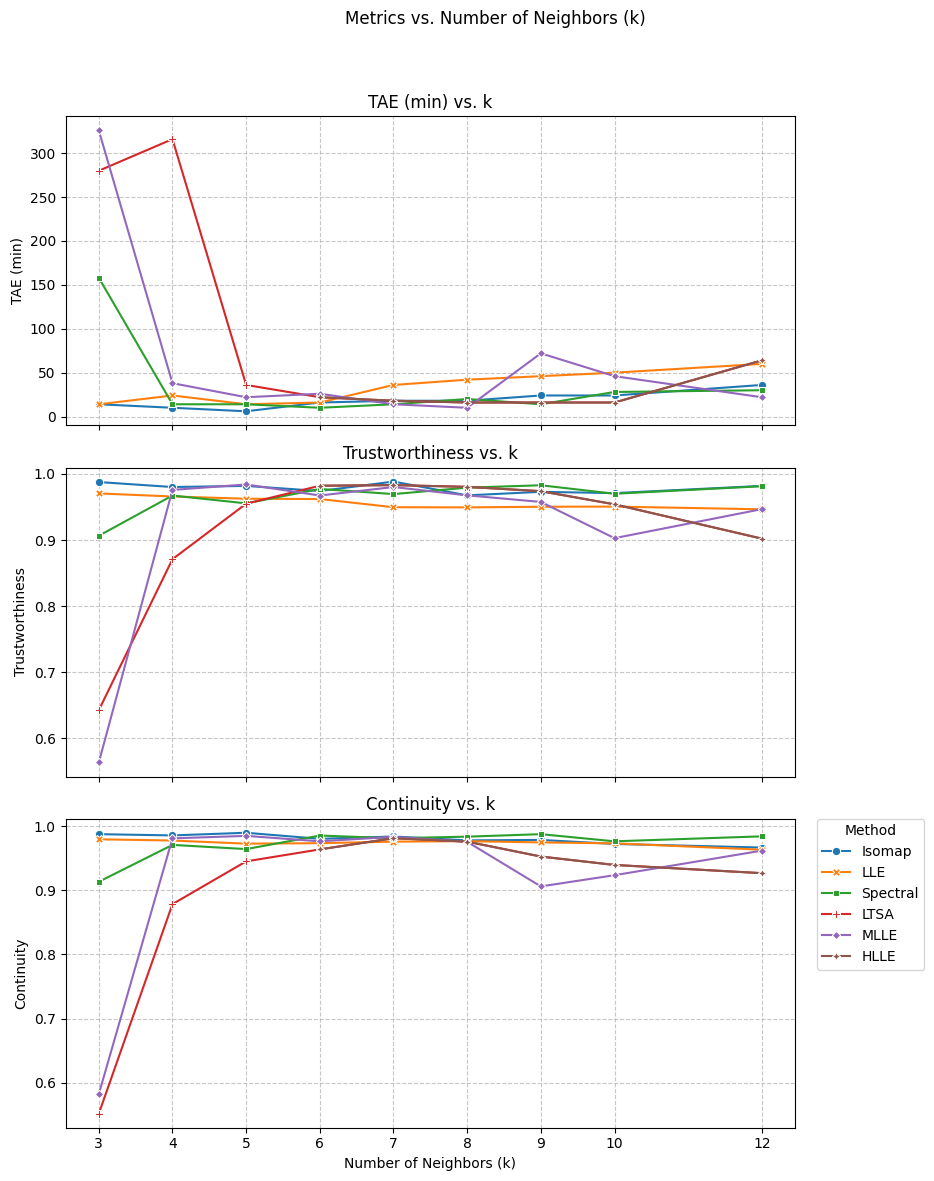

In [5]:
# Cell 5: Visualize Neighbor Tuning Results (Metrics vs. k) - CORRECTED LEGEND v2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported

print("\n--- Visualizing Neighbor Tuning Metrics (Refined with Legend) ---")

# Check if results DataFrame exists
if 'param_tuning_results_k_df' in locals() and not param_tuning_results_k_df.empty:
    # Make sure k is numeric for plotting if it's not already
    try:
        param_tuning_results_k_df['k'] = pd.to_numeric(param_tuning_results_k_df['k'])
    except Exception as e:
        print(f"Warning: Could not convert 'k' column to numeric: {e}")

    metrics_to_plot = ['TAE (min)', 'Trustworthiness', 'Continuity']
    n_metrics = len(metrics_to_plot)

    fig, axes = plt.subplots(n_metrics, 1, figsize=(10, n_metrics * 4), sharex=True) # Keep width reasonable
    fig.suptitle('Metrics vs. Number of Neighbors (k)')

    methods_tuned_k = param_tuning_results_k_df['Method'].unique()

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        try:
             # Let seaborn handle the legend creation by default within lineplot
             # We will hide legends on upper plots and only show on the last one
             sns.lineplot(data=param_tuning_results_k_df, x='k', y=metric, hue='Method',
                          style='Method', markers=True, dashes=False, ax=ax) # Use style and markers
             ax.set_ylabel(metric)
             ax.set_title(f'{metric} vs. k')
             ax.grid(True, linestyle='--', alpha=0.7)
             # Use the refined k_values for x-axis ticks
             if 'k_values_refined' in locals():
                  ax.set_xticks(k_values_refined)
             else: # Fallback if refined list isn't available
                  ax.set_xticks(param_tuning_results_k_df['k'].unique())

             # Hide legend on all but the last plot
             if i < n_metrics - 1:
                  ax.legend().set_visible(False)
             else:
                  # Place legend outside the last plot
                  ax.legend(title='Method', bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)

        except Exception as e:
             print(f"Could not plot {metric}: {e}")
             ax.set_title(f'Error plotting {metric}')

    axes[-1].set_xlabel('Number of Neighbors (k)')
    plt.tight_layout(rect=[0, 0, 0.9, 0.95]) # Adjust rect slightly more if legend overlaps
    plt.subplots_adjust(right=0.8) # Make more room for the legend on the right
    plt.show()

else:
    print("No results available from neighbor tuning to visualize.")

In [6]:
# Cell 7: Parameter Tuning for t-SNE (Varying Perplexity)
import time
import pandas as pd

print("\n--- Tuning t-SNE (Perplexity) ---")

# Check data and functions
if flattened_face_data is None or ground_truth_order_indices is None or compute_all_metrics is None or run_tsne is None:
    print("Error: Missing necessary data or functions. Cannot proceed.")
else:
    # perplexity_values should be defined in Cell 3 ([5, 10, 15, 20, 30])
    if 'perplexity_values' not in locals():
         perplexity_values = [5, 10, 15, 20, 30] # Define if missing
         print(f"Using default perplexity values: {perplexity_values}")

    tsne_results_list = []
    start_tsne_time = time.time()

    for p in perplexity_values:
        print(f"\n--- Running t-SNE with perplexity = {p} ---")
        tsne_embedding_p = None
        try:
             # Note: t-SNE perplexity must be less than n_samples - 1
             if p >= flattened_face_data.shape[0] -1 :
                  print(f"Skipping perplexity {p}: must be < n_samples-1 ({flattened_face_data.shape[0]-1})")
                  continue

             tsne_embedding_p, _ = run_tsne(flattened_face_data,
                                            n_components=n_components, # Use n_components=2
                                            perplexity=p,
                                            random_state=random_state) # Use same random_state
             current_embedding_dict = {'t-SNE': tsne_embedding_p}

             # Calculate metrics
             metrics_df_p = compute_all_metrics(flattened_face_data,
                                               current_embedding_dict,
                                               ground_truth_order_indices,
                                               n_neighbors=metrics_k_for_TC) # Use fixed k for T/C

             # Add perplexity value and store
             if not metrics_df_p.empty:
                  metrics_df_p['perplexity'] = p
                  tsne_results_list.extend(metrics_df_p.to_dict('records'))
                  print(f"Metrics for perplexity={p}:\n{metrics_df_p}\n")
             else:
                  print(f"Metric calculation failed for perplexity={p}.")

        except Exception as e:
            print(f"t-SNE (perplexity={p}) failed: {e}")

    end_tsne_time = time.time()
    print(f"--- t-SNE tuning completed in {end_tsne_time - start_tsne_time:.2f} seconds ---")

# Convert results to DataFrame
param_tuning_results_tsne_df = pd.DataFrame(tsne_results_list)
print("\n--- t-SNE Tuning Results Summary ---")
if not param_tuning_results_tsne_df.empty:
    print(param_tuning_results_tsne_df)
else:
    print("No results generated for t-SNE tuning.")


--- Tuning t-SNE (Perplexity) ---
Using default perplexity values: [5, 10, 15, 20, 30]

--- Running t-SNE with perplexity = 5 ---
Running t-SNE with n_components=2, perplexity=5...
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 33 samples in 0.000s...
[t-SNE] Computed neighbors for 33 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 33 / 33
[t-SNE] Mean sigma: 50.230313
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.602135
[t-SNE] KL divergence after 1000 iterations: 0.066393
t-SNE completed.
Metrics for perplexity=5:
  Method  TAE (min)  Trustworthiness  Continuity  perplexity
0  t-SNE         96         0.979394    0.988364           5


--- Running t-SNE with perplexity = 10 ---
Running t-SNE with n_components=2, perplexity=10...
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 33 samples in 0.000s...
[t-SNE] Computed neighbors for 33 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 33 /


--- Visualizing t-SNE Tuning Metrics (Refined) ---


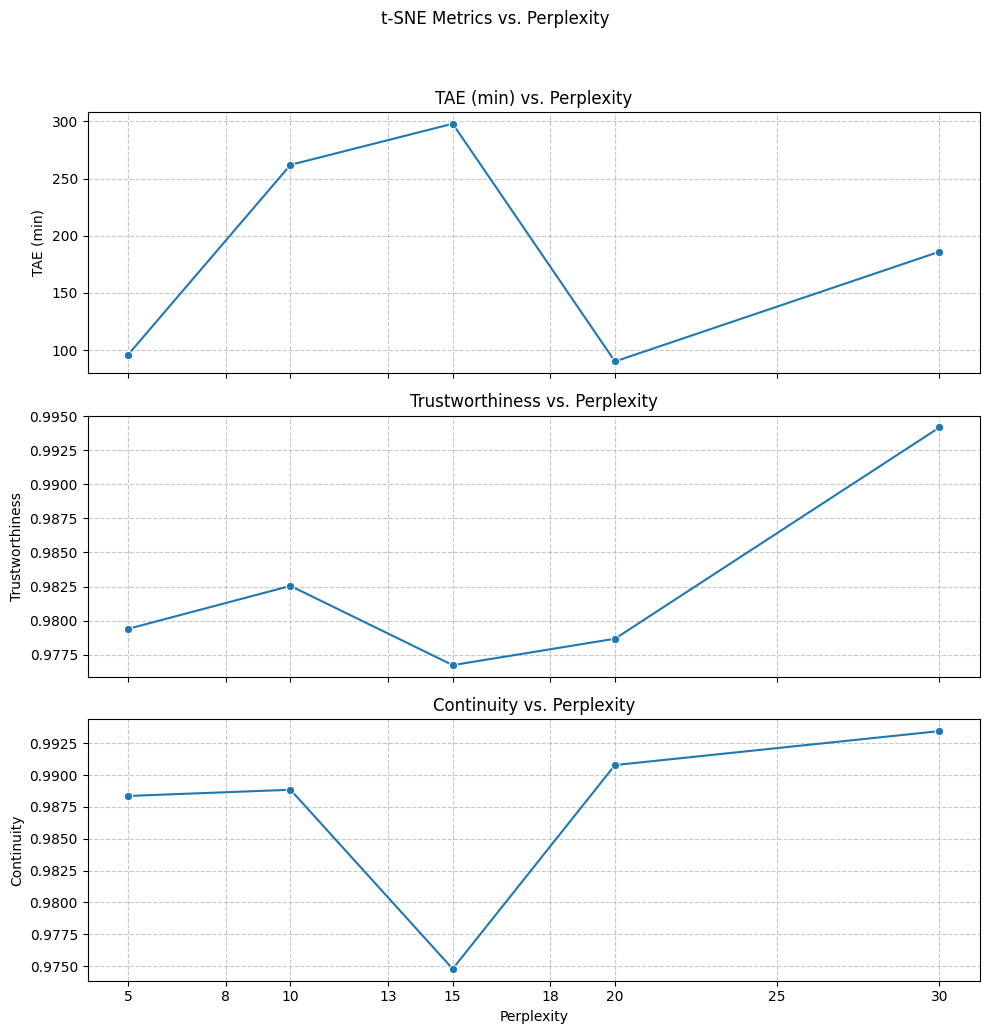

In [7]:
# Cell 8: Visualize t-SNE Tuning Results (Metrics vs. Perplexity) - IMPROVED LEGEND
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Visualizing t-SNE Tuning Metrics (Refined) ---")

# Check if results DataFrame exists (should be named param_tuning_results_tsne_df)
if 'param_tuning_results_tsne_df' in locals() and not param_tuning_results_tsne_df.empty:

    metrics_to_plot = ['TAE (min)', 'Trustworthiness', 'Continuity']
    n_metrics = len(metrics_to_plot)

    fig, axes = plt.subplots(n_metrics, 1, figsize=(10, n_metrics * 3.5), sharex=True) # Slightly wider
    fig.suptitle('t-SNE Metrics vs. Perplexity')

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        try:
             # Use lineplot with markers
             sns.lineplot(data=param_tuning_results_tsne_df, x='perplexity', y=metric, marker='o', ax=ax, errorbar=None)
             ax.set_ylabel(metric)
             ax.set_title(f'{metric} vs. Perplexity')
             ax.grid(True, linestyle='--', alpha=0.7)
             ax.set_xticks(perplexity_values_refined) # Ensure all tested perplexities are marked
        except Exception as e:
             print(f"Could not plot {metric}: {e}")
             ax.set_title(f'Error plotting {metric}')

    axes[-1].set_xlabel('Perplexity')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    print("No results available from t-SNE tuning to visualize.")

In [8]:
# Cell 9: Run Embeddings with Optimal Parameters Found
import time
print("--- Running Embeddings with Optimal Parameters ---")

optimal_embeddings_dict = {} # Store optimal results here

# Check if data and functions are available
if ('flattened_face_data' not in locals() or flattened_face_data is None or
    'run_pca' not in locals() or 'run_mds' not in locals() or
    'run_isomap' not in locals() or 'run_lle' not in locals() or
    'run_spectral' not in locals() or 'run_tsne' not in locals()):
    print("Error: Prerequisite data or embedding functions not found. Run previous cells.")
else:
    start_optimal_time = time.time()
    random_state = 42 # Keep random state consistent

    # Define optimal parameters
    optimal_params = {
        'PCA': {'n_components': 2},
        'MDS': {'n_components': 2, 'random_state': random_state},
        'Isomap': {'n_components': 2, 'n_neighbors': 5},
        'LLE': {'n_components': 2, 'n_neighbors': 5, 'method': 'standard', 'random_state': random_state},
        'LTSA': {'n_components': 2, 'n_neighbors': 10, 'method': 'ltsa', 'random_state': random_state},
        'MLLE': {'n_components': 2, 'n_neighbors': 12, 'method': 'modified', 'random_state': random_state},
        'HLLE': {'n_components': 2, 'n_neighbors': 10, 'method': 'hessian', 'random_state': random_state},
        'Spectral': {'n_components': 2, 'n_neighbors': 5, 'random_state': random_state},
        't-SNE': {'n_components': 2, 'perplexity': 20, 'random_state': random_state}
    }

    # Functions mapping (adjust if your function names differ)
    func_map = {
        'PCA': run_pca, 'MDS': run_mds, 'Isomap': run_isomap,
        'LLE': run_lle, 'LTSA': run_lle, 'MLLE': run_lle, 'HLLE': run_lle,
        'Spectral': run_spectral, 't-SNE': run_tsne
    }

    # Run each method with its optimal parameters
    for name, params in optimal_params.items():
        func = func_map.get(name)
        if func:
            print(f"Running {name} with optimal params: {params}...")
            try:
                 optimal_embeddings_dict[name], _ = func(flattened_face_data, **params)
            except Exception as e:
                 print(f"{name} failed with optimal params: {e}")
                 optimal_embeddings_dict[name] = None
        else:
             print(f"Function for {name} not found.")
             optimal_embeddings_dict[name] = None

    end_optimal_time = time.time()
    print(f"\n--- Optimal embeddings computed in {end_optimal_time - start_optimal_time:.2f} seconds ---")

    print("\nOptimal Embedding Shapes:")
    for name, emb in optimal_embeddings_dict.items():
        if emb is not None: print(f" {name}: {emb.shape}")
        else: print(f" {name}: Failed or not run.")

--- Running Embeddings with Optimal Parameters ---
Running PCA with optimal params: {'n_components': 2}...
Running PCA with n_components=2...
PCA completed.
Running MDS with optimal params: {'n_components': 2, 'random_state': 42}...
Running MDS with n_components=2...


/opt/anaconda3/envs/tgdr39/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 234 with stress 194136196.054825
breaking at iteration 115 with stress 194855075.18209332
breaking at iteration 149 with stress 186688840.16468853
breaking at iteration 152 with stress 195547039.71726066
MDS completed.
Running Isomap with optimal params: {'n_components': 2, 'n_neighbors': 5}...
Running Isomap with n_components=2, n_neighbors=5...
Isomap completed.
Running LLE with optimal params: {'n_components': 2, 'n_neighbors': 5, 'method': 'standard', 'random_state': 42}...
Running LLE (method='standard') with n_components=2, n_neighbors=5...
LLE (method='standard') completed.
Running LTSA with optimal params: {'n_components': 2, 'n_neighbors': 10, 'method': 'ltsa', 'random_state': 42}...
Running LLE (method='ltsa') with n_components=2, n_neighbors=10...
LLE (method='ltsa') completed.
Running MLLE with optimal params: {'n_components': 2, 'n_neighbors': 12, 'method': 'modified', 'random_state': 42}...
Running LLE (method='modified') with n_components=2, n_neigh

In [9]:
# Cell 10: Calculate Final Metrics Table (Optimal Parameters)
import pandas as pd

print("\n--- Calculating Final Metrics with Optimal Parameters ---")
final_metrics_df = None

if ('flattened_face_data' not in locals() or flattened_face_data is None or
    'ground_truth_order_indices' not in locals() or ground_truth_order_indices is None or
    'compute_all_metrics' not in locals() or compute_all_metrics is None or
    'optimal_embeddings_dict' not in locals() or not optimal_embeddings_dict):
    print("Error: Missing necessary data, function, or optimal embeddings.")
else:
    # Filter out None values
    valid_optimal_embeddings = {name: emb for name, emb in optimal_embeddings_dict.items() if emb is not None}

    if not valid_optimal_embeddings:
         print("Error: No valid optimal embeddings found.")
    else:
         # Calculate metrics (using k=5 for T&C calculation itself, or perhaps optimal k per method?)
         # Let's use optimal k for T&C for each method where applicable for final analysis
         # Need to slightly modify compute_all_metrics or calculate individually
         # For simplicity now, let's stick with k=5 for T&C calculation.
         # We can refine this later if needed.
         metrics_k_final = 5
         final_metrics_df = compute_all_metrics(flattened_face_data,
                                                valid_optimal_embeddings,
                                                ground_truth_order_indices,
                                                n_neighbors=metrics_k_final)

         print(f"\n--- Final Evaluation Metrics (Optimal Params, k={metrics_k_final} for T&C) ---")
         pd.set_option('display.float_format', '{:.4f}'.format)
         print(final_metrics_df)


--- Calculating Final Metrics with Optimal Parameters ---
Note: TAE for MDS was calculated using reversed order (min(366, 350)).
Note: TAE for LLE was calculated using reversed order (min(544, 14)).
Note: TAE for LTSA was calculated using reversed order (min(544, 16)).
Note: TAE for HLLE was calculated using reversed order (min(544, 16)).
Note: TAE for Spectral was calculated using reversed order (min(544, 14)).

--- Final Evaluation Metrics (Optimal Params, k=5 for T&C) ---
     Method  TAE (min)  Trustworthiness  Continuity
2    Isomap          6           0.9818      0.9898
3       LLE         14           0.9624      0.9728
7  Spectral         14           0.9554      0.9644
4      LTSA         16           0.9539      0.9396
6      HLLE         16           0.9539      0.9396
5      MLLE         22           0.9467      0.9619
0       PCA         30           0.9782      0.9908
8     t-SNE         90           0.9787      0.9908
1       MDS        350           0.9864      0.9818


--- Visualizing Final Embeddings (Scatter) ---


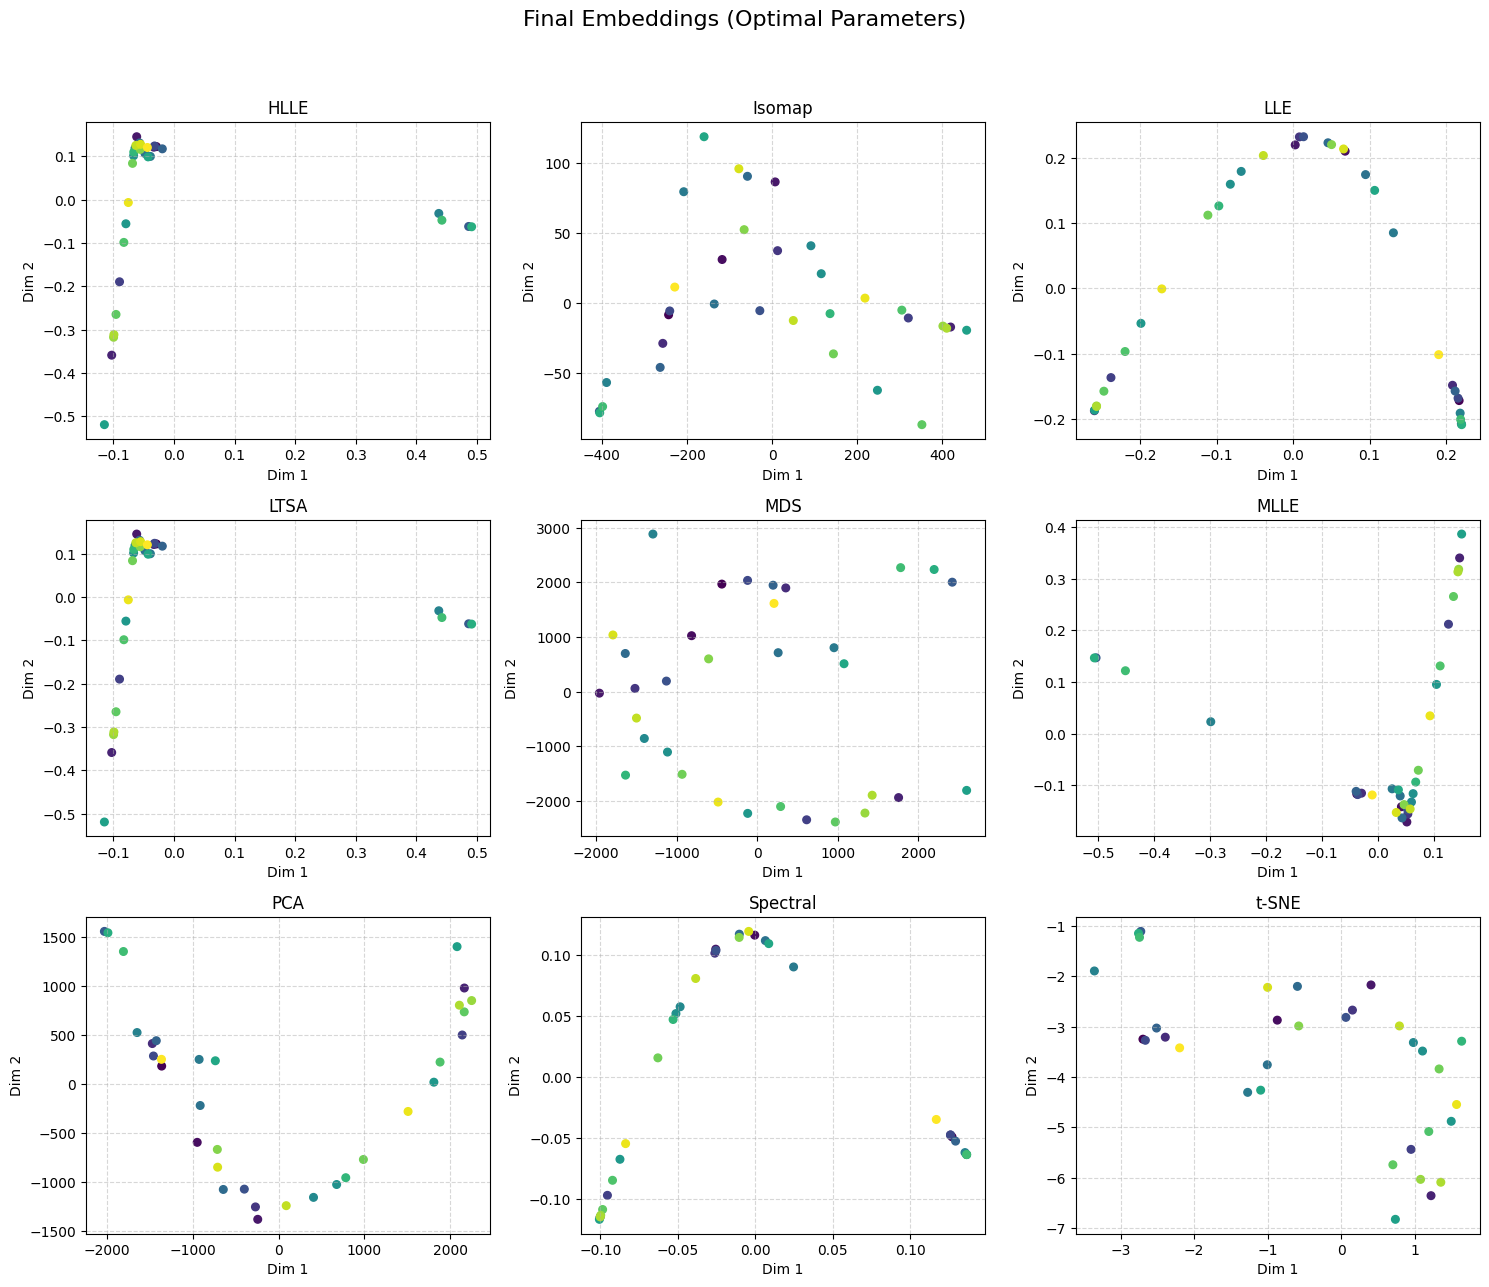

In [10]:
# Cell 11: Visualize Final Embeddings (Scatter Plots - Optimal Params)
import matplotlib.pyplot as plt
import numpy as np

print("\n--- Visualizing Final Embeddings (Scatter) ---")

if 'final_metrics_df' not in locals() or final_metrics_df is None:
     print("Error: Final metrics DataFrame not available. Cannot determine methods to plot.")
elif 'optimal_embeddings_dict' not in locals() or not optimal_embeddings_dict:
     print("Error: Optimal embeddings dictionary not available.")
else:
    # Use methods present in the final metrics dataframe
    methods_to_plot_final = final_metrics_df['Method'].tolist()
    available_embeddings_final = {name: optimal_embeddings_dict[name] for name in methods_to_plot_final if optimal_embeddings_dict.get(name) is not None}

    if not available_embeddings_final:
        print("No valid optimal embeddings available for plotting.")
    else:
        n_methods_final = len(available_embeddings_final)
        n_cols_final = 3
        n_rows_final = (n_methods_final + n_cols_final - 1) // n_cols_final
        fig, axes = plt.subplots(n_rows_final, n_cols_final, figsize=(n_cols_final * 5, n_rows_final * 4.5), squeeze=False)
        fig.suptitle('Final Embeddings (Optimal Parameters)', fontsize=16)

        axes_flat = axes.flatten()
        plot_idx = 0
        # Plot in order of Method name for consistency
        for name in sorted(available_embeddings_final.keys()):
            emb = available_embeddings_final[name]
            if plot_idx < len(axes_flat):
                 ax = axes_flat[plot_idx]
                 # Get optimal params string for title (optional)
                 params_str = str(optimal_params.get(name, {}))
                 ax.set_title(f"{name}") # Keep title simple for now
                 scatter = ax.scatter(emb[:, 0], emb[:, 1], c=np.arange(emb.shape[0]), cmap='viridis', s=30)
                 ax.set_xlabel('Dim 1')
                 ax.set_ylabel('Dim 2')
                 ax.grid(True, linestyle='--', alpha=0.5)
                 plot_idx += 1
            else: break

        for j in range(plot_idx, len(axes_flat)): axes_flat[j].axis('off')
        if plot_idx > 0: plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()


--- Visualizing Final Embeddings with Images ---


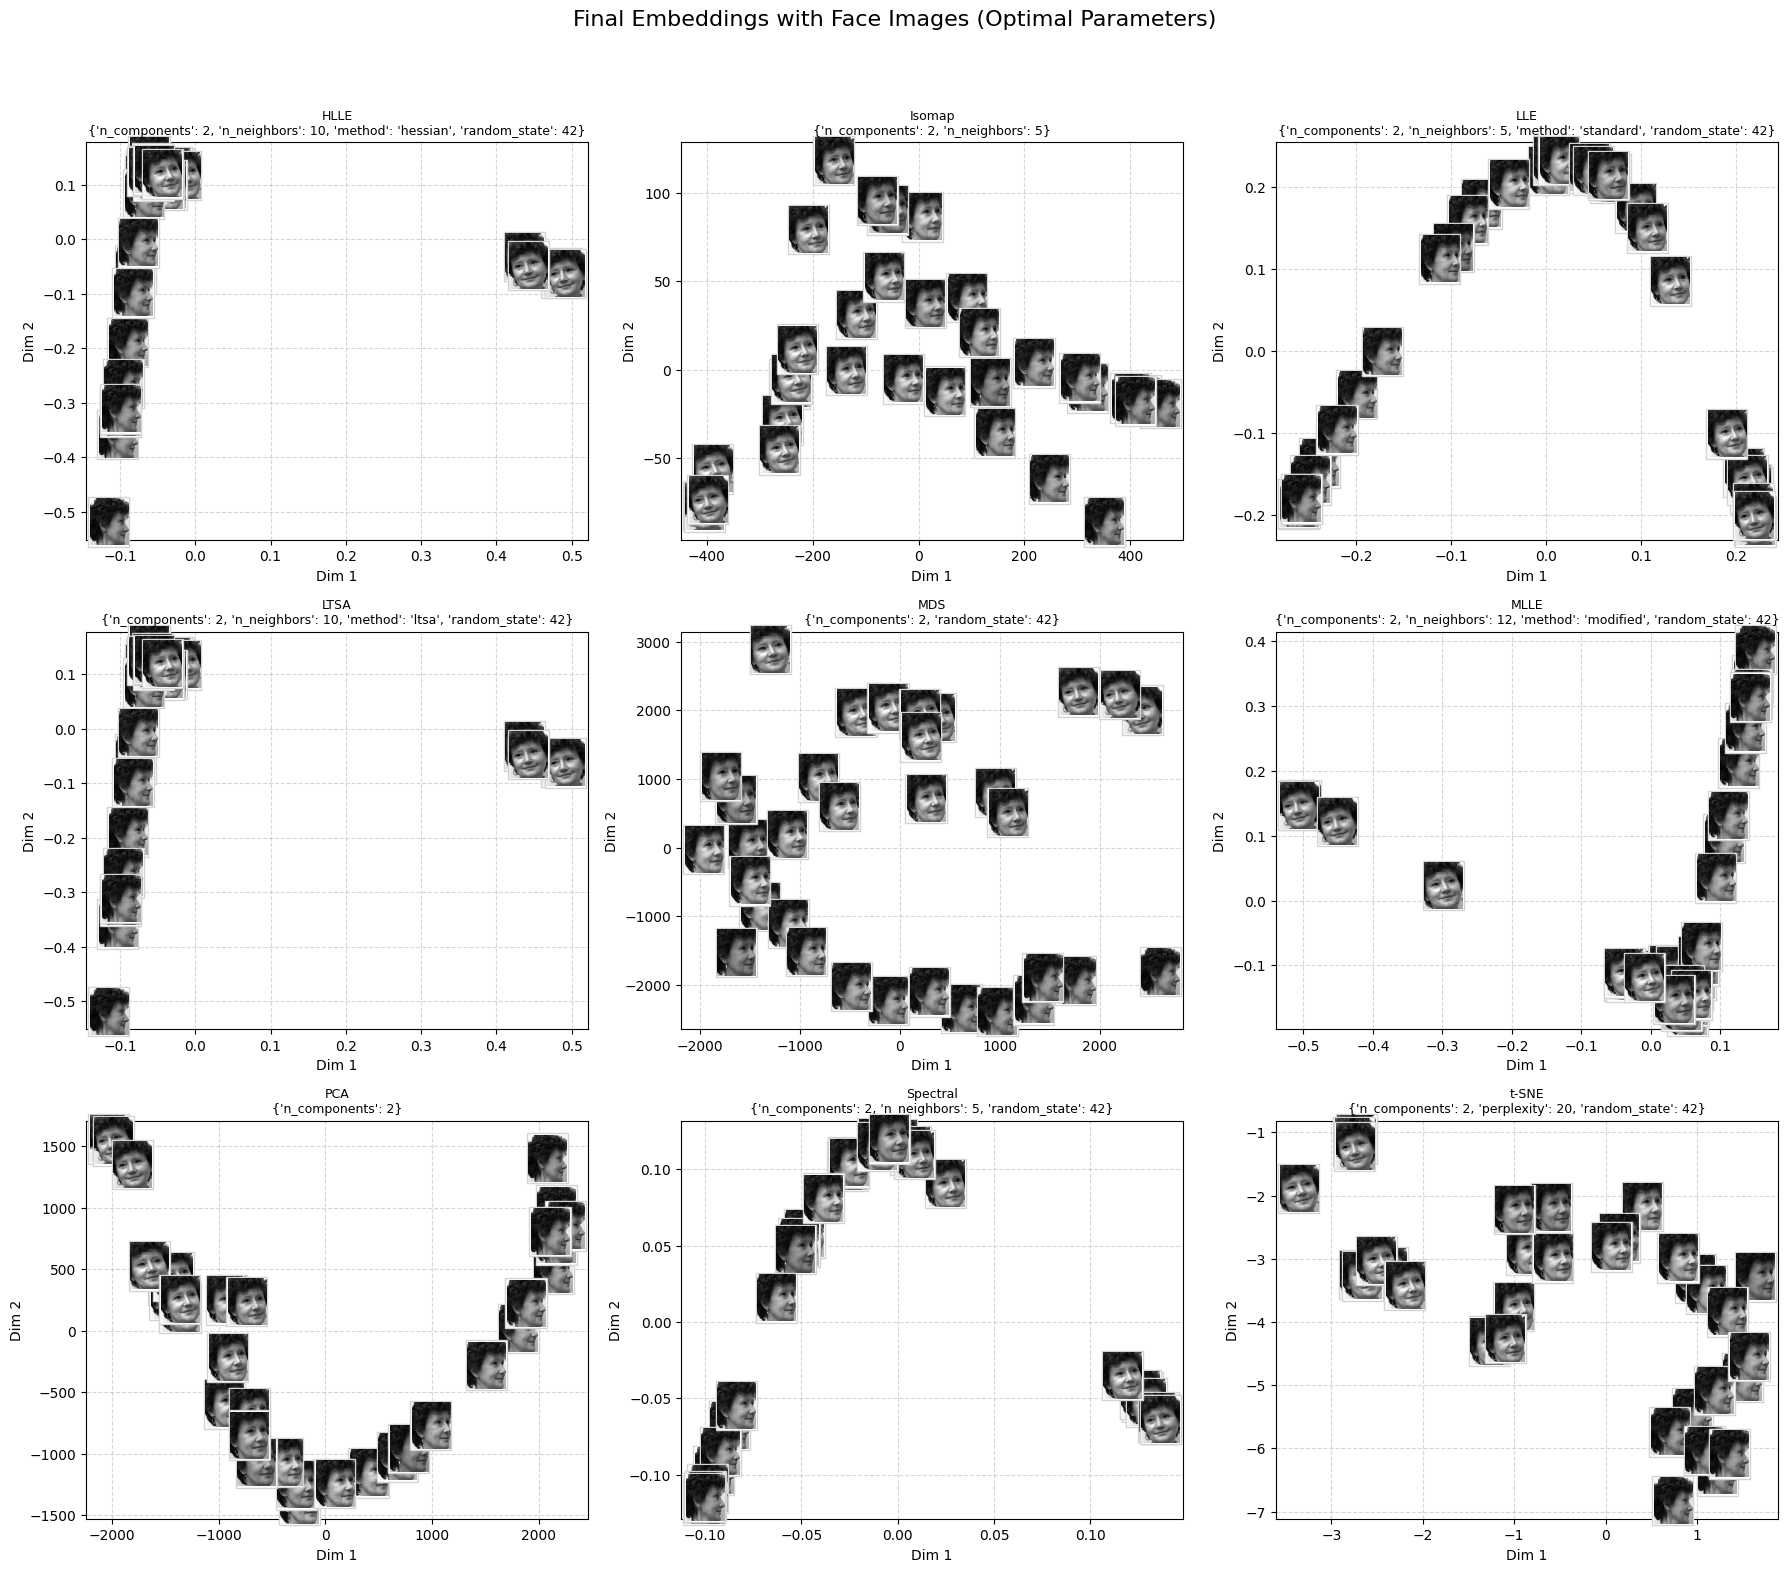

In [11]:
# Cell 12: Visualize Final Embeddings with Images (Optimal Params)
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

print("\n--- Visualizing Final Embeddings with Images ---")

if 'face_data' not in locals() or face_data is None:
     print("Raw face_data not found.")
elif 'final_metrics_df' not in locals() or final_metrics_df is None:
     print("Error: Final metrics DataFrame not available.")
elif 'optimal_embeddings_dict' not in locals() or not optimal_embeddings_dict:
     print("Error: Optimal embeddings dictionary not available.")
else:
    methods_to_plot_img = final_metrics_df['Method'].tolist()
    available_embeddings_img_final = {name: optimal_embeddings_dict[name] for name in methods_to_plot_img if optimal_embeddings_dict.get(name) is not None}

    if not available_embeddings_img_final:
         print("No valid optimal embeddings available for image plotting.")
    else:
        n_methods_img_final = len(available_embeddings_img_final)
        n_cols_img_final = 3
        n_rows_img_final = (n_methods_img_final + n_cols_img_final - 1) // n_cols_img_final
        fig_img, axes_img = plt.subplots(n_rows_img_final, n_cols_img_final, figsize=(n_cols_img_final * 6, n_rows_img_final * 5.5), squeeze=False)
        fig_img.suptitle("Final Embeddings with Face Images (Optimal Parameters)", fontsize=16)
        axes_flat_img = axes_img.flatten()
        plot_idx_img = 0

        for name in sorted(available_embeddings_img_final.keys()):
            embedding = available_embeddings_img_final[name]
            if plot_idx_img >= len(axes_flat_img): break
            ax = axes_flat_img[plot_idx_img]
            # Get optimal params for title
            params_used = optimal_params.get(name, {})
            title_str = f"{name}\n{params_used}"
            ax.set_title(title_str, fontsize=9)
            ax.set_xlabel("Dim 1")
            ax.set_ylabel("Dim 2")
            x_coords = embedding[:, 0]
            y_coords = embedding[:, 1]

            for i in range(face_data.shape[0]):
                x, y = x_coords[i], y_coords[i]
                img = face_data[i, :, :].T
                try:
                    imagebox = OffsetImage(img, zoom=0.3, cmap='gray')
                    imagebox.image.axes = ax
                    ab = AnnotationBbox(imagebox, (x, y), xycoords='data', frameon=True, pad=0.1, bboxprops=dict(edgecolor='lightgray'))
                    ax.add_artist(ab)
                    # Add original index (0-based)
                    # ax.text(x, y, str(i), color='red', fontsize=7, weight='bold', ha='right', va='top')
                except Exception as e:
                    print(f"Warn: Img {i} for {name}: {e}")

            ax.update_datalim(np.column_stack([x_coords, y_coords]))
            ax.autoscale_view()
            ax.grid(True, linestyle='--', alpha=0.5)
            plot_idx_img += 1

        for j in range(plot_idx_img, len(axes_flat_img)): axes_flat_img[j].axis('off')
        if plot_idx_img > 0: plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()